Multivariate Time Series Forecasting with LSTMs in Keras:
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

**Data preparation**

In [1]:
import pandas as pd
from datetime import datetime

def parse_date(d):
    return datetime.strptime(d, '%Y %m %d %H')

#load data
data = pd.read_csv('raw.csv',
                   parse_dates=[['year', 'month', 'day', 'hour']], 
                   index_col=0, 
                   date_parser=parse_date)

data.drop('No', axis=1, inplace=True)

data.columns = ['Pollution', 
                'Dew', 
                'Temp', 
                'Press', 
                'Wnd_dir', 
                'Wnd_spd', 
                'Snow', 
                'Rain']
data.index.name = 'Date'

# Change all NA values with 0
data['Pollution'].fillna(0, inplace=True)

# Drop the first 24 hours
data = data[24:]

print(data.head())

# Save to file
data.to_csv('pollution.csv')

                     Pollution  Dew  Temp   Press Wnd_dir  Wnd_spd  Snow  Rain
Date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


**Plot data**

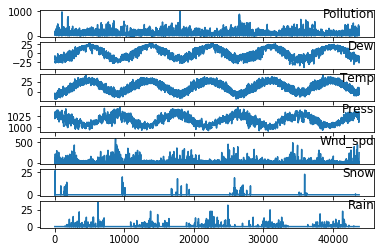

In [2]:
from matplotlib import pyplot
%matplotlib inline

# Get the numpy values
values = data.values

# Columns to plot
cols = [0, 1, 2, 3, 5, 6, 7]
i = 1

# Plot each column
pyplot.figure()
for col in cols:
    pyplot.subplot(len(cols), 1, i)
    pyplot.plot(values[:, col])
    pyplot.title(data.columns[col], y=0.5, loc='right')
    i += 1
    
pyplot.show()

**LSTM Data preparation**

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Integer encode wind direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])

values = values.astype('float32')

# Normalize features 
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# Frame as supervised learning
reframed = series_to_supervised(scaled)

# Drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


**Create train and test sets.**

In [5]:
# Split into train and test sets
values = reframed.values
nb_train_hours = 1 * 365 * 24
train = values[:nb_train_hours, :]
test = values[nb_train_hours:, :]

# Split into inputs and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


**Define and Fit the model**

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 5s - loss: 0.0565 - val_loss: 0.0613
Epoch 2/50
 - 2s - loss: 0.0376 - val_loss: 0.0632
Epoch 3/50
 - 2s - loss: 0.0235 - val_loss: 0.0514
Epoch 4/50
 - 2s - loss: 0.0184 - val_loss: 0.0480
Epoch 5/50
 - 2s - loss: 0.0166 - val_loss: 0.0344
Epoch 6/50
 - 2s - loss: 0.0154 - val_loss: 0.0231
Epoch 7/50
 - 2s - loss: 0.0151 - val_loss: 0.0204
Epoch 8/50
 - 2s - loss: 0.0149 - val_loss: 0.0187
Epoch 9/50
 - 2s - loss: 0.0148 - val_loss: 0.0177
Epoch 10/50
 - 2s - loss: 0.0147 - val_loss: 0.0163
Epoch 11/50
 - 2s - loss: 0.0146 - val_loss: 0.0158
Epoch 12/50
 - 2s - loss: 0.0146 - val_loss: 0.0154
Epoch 13/50
 - 2s - loss: 0.0146 - val_loss: 0.0148
Epoch 14/50
 - 2s - loss: 0.0146 - val_loss: 0.0145
Epoch 15/50
 - 2s - loss: 0.0146 - val_loss: 0.0144
Epoch 16/50
 - 2s - loss: 0.0145 - val_loss: 0.0144
Epoch 17

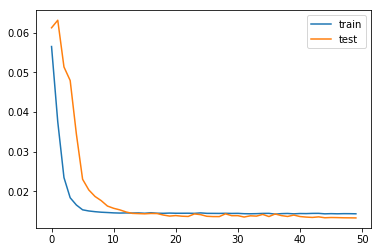

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Create network: 
#   - 1st layer: 50 LSTM neurons, input shape = 1 time step x 8 features
#   - Output layer: 1 neuron
#   - Loss function: Mean Absolute Error
#   - Optimizer: Adam version of stochastic gradient descent
model = Sequential([LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])),
                    Dense(1)])
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2,
                    shuffle=False)

# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Evaluate the model**

In [7]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

# Make the prediction
y_hat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_y_hat = np.concatenate((y_hat, test_X[:, 1:]), axis=1)
inv_y_hat = scaler.inverse_transform(inv_y_hat)
inv_y_hat = inv_y_hat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# Calculate Root Mean Squared Error
rmse = math.sqrt(mean_squared_error(inv_y, inv_y_hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.408


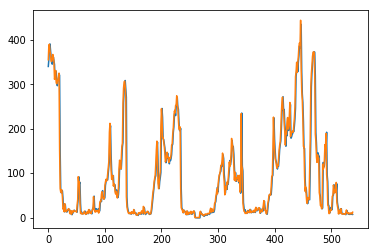

In [12]:
pyplot.plot(inv_y_hat[34500:], label='y_hat')
pyplot.plot(inv_y[34500:], label='y')
pyplot.show()